In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import make_pipeline
import seaborn as sns
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# загрузка и объединение данных из файлов в один датафрейм
files = glob("/content/drive/MyDrive/NN_labs/lab_1/*.csv")
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
df.head()

,touches_size_exists,touches_size_min,touches_size_mean,touches_size_max,touches_size_std,gyroscope_exists,gyroscope_x_min,gyroscope_x_mean,gyroscope_x_max,gyroscope_x_std,...,accelerometer_z_min,accelerometer_z_mean,accelerometer_z_max,accelerometer_z_std,light_exists,light_min,light_mean,light_max,light_std,label
0,1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1
1,1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1
2,1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1
3,1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1
4,1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1


In [ ]:
df.drop_duplicates(inplace=True)
df.shape

(8445, 37)

Начинаем работу с торчом

In [ ]:
import torch
import torch.nn as nn
from torch import optim
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
y = df['label'].values
X = df.drop('label', axis=1).values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle = False)
dataloaders = {"train": train_dataloader, "valid": val_dataloader}

In [ ]:
def fit_one_epoch(model, train_dataloader, optimizer, loss_func):
  epoch_correct_predictions = 0.0
  epoch_all_predictions = 0.0
  losses = []

  model.train()

  for X_batch, y_batch in tqdm(train_dataloader):
    optimizer.zero_grad()
    outp = model(X_batch)
    loss = loss_func(outp, y_batch)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

    probabilities = torch.sigmoid(outp)
    preds = (probabilities > 0.5).type(torch.float32)
    batch_correct_predictions = (preds == y_batch).sum()
    batch_all_predictions = len(preds)

    epoch_correct_predictions += batch_correct_predictions
    epoch_all_predictions += batch_all_predictions

  epoch_accuracy = epoch_correct_predictions/epoch_all_predictions
  epoch_loss = sum(losses)/len(losses)
  return epoch_accuracy, epoch_loss

In [ ]:
def eval_one_epoch(model, val_dataloader, loss_func):

  epoch_correct_predictions = 0.0
  epoch_all_predictions = 0.0
  losses = []

  model.eval()

  for X_batch, y_batch in tqdm(val_dataloader):
    with torch.no_grad():
      outp = model(X_batch)
      loss = loss_func(outp, y_batch)
      losses.append(loss.item())
      probabilities = torch.sigmoid(outp)

    preds = (probabilities > 0.5).type(torch.float32)
    batch_correct_predictions = (preds == y_batch).sum()
    batch_all_predictions = len(preds)

    epoch_correct_predictions +=  batch_correct_predictions
    epoch_all_predictions += batch_all_predictions

  epoch_accuracy = epoch_correct_predictions/epoch_all_predictions
  epoch_loss = sum(losses)/len(losses)
  return epoch_accuracy, epoch_loss

In [ ]:
def train_func(model, num_epochs, dataloaders, optimizer, loss_func):
  accuracy = {"train": [], "valid": []}
  loss = {"train": [], "valid": []}
  for epoch in range(num_epochs):
    print(f"\nEpoch: {epoch+1}")

    accuracy_train_one_epoch, loss_train_one_epoch = fit_one_epoch(model = model, train_dataloader = dataloaders['train'], optimizer = optimizer, loss_func = loss_func)
    print(f"Accuracy_train: {accuracy_train_one_epoch.item()}")
    print(f"Loss_train: {loss_train_one_epoch}\n")

    accuracy_test_one_epoch, loss_test_one_epoch = eval_one_epoch(model = model, val_dataloader = dataloaders['valid'], loss_func = loss_func)
    print(f"Accuracy_test: {accuracy_test_one_epoch.item()}")
    print(f"Loss_test: {loss_test_one_epoch}\n")

    accuracy['train'].append(accuracy_train_one_epoch)
    accuracy['valid'].append(accuracy_test_one_epoch)

    loss['train'].append(loss_train_one_epoch)
    loss['valid'].append(loss_test_one_epoch)

  return accuracy, loss

In [ ]:
def test_activation_function(activation):
    model = nn.Sequential(
        nn.Linear(36, 5),
        activation,
        nn.Linear(5, 5),
        activation,
        nn.Linear(5, 5),
        activation,
        nn.Linear(5, 1),
        )
    optimizer = torch.optim.SGD(model.parameters())
    criterion = nn.BCEWithLogitsLoss()
    max_epochs = 10
    accuracy, loss = train_func(model =  model, num_epochs = max_epochs, dataloaders = dataloaders, optimizer = optimizer, loss_func = criterion)

    return accuracy, loss

In [ ]:
sigmoid_accuracy, sigmoid_loss = test_activation_function(nn.Sigmoid())
tanh_accuracy, tanh_loss = test_activation_function(nn.Tanh())
relu_accuracy, relu_loss = test_activation_function(nn.ReLU())


Epoch: 1


100%|██████████| 53/53 [00:00<00:00, 442.37it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.7015838128215862



100%|██████████| 14/14 [00:00<00:00, 679.16it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.7075932792254856


Epoch: 2


100%|██████████| 53/53 [00:00<00:00, 495.97it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.7006101529553251



100%|██████████| 14/14 [00:00<00:00, 596.98it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.7064268376146045


Epoch: 3


100%|██████████| 53/53 [00:00<00:00, 323.45it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.699338141477333



100%|██████████| 14/14 [00:00<00:00, 700.88it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.7053268466676984


Epoch: 4


100%|██████████| 53/53 [00:00<00:00, 468.04it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6982439958824301



100%|██████████| 14/14 [00:00<00:00, 745.10it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.7042884358337947


Epoch: 5


100%|██████████| 53/53 [00:00<00:00, 478.56it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6974183028599001



100%|██████████| 14/14 [00:00<00:00, 678.68it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.7033025196620396


Epoch: 6


100%|██████████| 53/53 [00:00<00:00, 481.20it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6964080671094498



100%|██████████| 14/14 [00:00<00:00, 638.02it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.7023725126470838


Epoch: 7


100%|██████████| 53/53 [00:00<00:00, 302.63it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6955536896327756



100%|██████████| 14/14 [00:00<00:00, 472.73it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.7014923053128379


Epoch: 8


100%|██████████| 53/53 [00:00<00:00, 319.42it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6948465063886823



100%|██████████| 14/14 [00:00<00:00, 451.92it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.7006576572145734


Epoch: 9


100%|██████████| 53/53 [00:00<00:00, 319.28it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6943997583299313



100%|██████████| 14/14 [00:00<00:00, 469.96it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.6998625014509473


Epoch: 10


100%|██████████| 53/53 [00:00<00:00, 348.24it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.693669004260369



100%|██████████| 14/14 [00:00<00:00, 413.22it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.6991118575845446


Epoch: 1


100%|██████████| 53/53 [00:00<00:00, 297.39it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6796743554889031



100%|██████████| 14/14 [00:00<00:00, 439.08it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.6822362925325122


Epoch: 2


100%|██████████| 53/53 [00:00<00:00, 328.93it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6787843985377617



100%|██████████| 14/14 [00:00<00:00, 486.63it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.6813017129898071


Epoch: 3


100%|██████████| 53/53 [00:00<00:00, 274.35it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6778810507846329



100%|██████████| 14/14 [00:00<00:00, 352.82it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.6802344151905605


Epoch: 4


100%|██████████| 53/53 [00:00<00:00, 276.37it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6766317644209232



100%|██████████| 14/14 [00:00<00:00, 400.67it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.679063366992133


Epoch: 5


100%|██████████| 53/53 [00:00<00:00, 277.22it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6752879608352229



100%|██████████| 14/14 [00:00<00:00, 286.30it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.6776832512446812


Epoch: 6


100%|██████████| 53/53 [00:00<00:00, 306.22it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6739797502193811



100%|██████████| 14/14 [00:00<00:00, 476.76it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.6760464608669281


Epoch: 7


100%|██████████| 53/53 [00:00<00:00, 322.16it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6723485206657985



100%|██████████| 14/14 [00:00<00:00, 415.64it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.6739482794489179


Epoch: 8


100%|██████████| 53/53 [00:00<00:00, 353.27it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6700885577021904



100%|██████████| 14/14 [00:00<00:00, 464.52it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.6719829951013837


Epoch: 9


100%|██████████| 53/53 [00:00<00:00, 316.69it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6684448381639877



100%|██████████| 14/14 [00:00<00:00, 406.79it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.6704516964299339


Epoch: 10


100%|██████████| 53/53 [00:00<00:00, 324.19it/s]


Accuracy_train: 0.5716400146484375

Loss_train: 0.6668790331426656



100%|██████████| 14/14 [00:00<00:00, 484.60it/s]


Accuracy_test: 0.5642392039299011

Loss_test: 0.6686169590268817


Epoch: 1


100%|██████████| 53/53 [00:00<00:00, 233.27it/s]


Accuracy_train: 0.4366489052772522

Loss_train: 0.8162556661749786



100%|██████████| 14/14 [00:00<00:00, 289.21it/s]


Accuracy_test: 0.46299585700035095

Loss_test: 0.7064087901796613


Epoch: 2


100%|██████████| 53/53 [00:00<00:00, 199.61it/s]


Accuracy_train: 0.46417999267578125

Loss_train: 0.6977597283867171



100%|██████████| 14/14 [00:00<00:00, 296.74it/s]


Accuracy_test: 0.44049733877182007

Loss_test: 0.6904598729951041


Epoch: 3


100%|██████████| 53/53 [00:00<00:00, 227.53it/s]


Accuracy_train: 0.4345766603946686

Loss_train: 0.6878270326920275



100%|██████████| 14/14 [00:00<00:00, 388.28it/s]


Accuracy_test: 0.4399052560329437

Loss_test: 0.6843679291861398


Epoch: 4


100%|██████████| 53/53 [00:00<00:00, 482.24it/s]


Accuracy_train: 0.43383657932281494

Loss_train: 0.6839425788735444



100%|██████████| 14/14 [00:00<00:00, 682.98it/s]


Accuracy_test: 0.44049733877182007

Loss_test: 0.6814584263733455


Epoch: 5


100%|██████████| 53/53 [00:00<00:00, 473.41it/s]


Accuracy_train: 0.4342806339263916

Loss_train: 0.6810083861620921



100%|██████████| 14/14 [00:00<00:00, 716.61it/s]


Accuracy_test: 0.441089391708374

Loss_test: 0.6787165190492358


Epoch: 6


100%|██████████| 53/53 [00:00<00:00, 477.13it/s]


Accuracy_train: 0.4354647696018219

Loss_train: 0.6781136123639233



100%|██████████| 14/14 [00:00<00:00, 588.54it/s]


Accuracy_test: 0.44168147444725037

Loss_test: 0.6762321804250989


Epoch: 7


100%|██████████| 53/53 [00:00<00:00, 478.98it/s]


Accuracy_train: 0.4527827203273773

Loss_train: 0.6754068676030861



100%|██████████| 14/14 [00:00<00:00, 754.28it/s]


Accuracy_test: 0.499703973531723

Loss_test: 0.6738371551036835


Epoch: 8


100%|██████████| 53/53 [00:00<00:00, 470.60it/s]


Accuracy_train: 0.48919478058815

Loss_train: 0.6726417417796153



100%|██████████| 14/14 [00:00<00:00, 590.24it/s]


Accuracy_test: 0.49674364924430847

Loss_test: 0.6704972343785423


Epoch: 9


100%|██████████| 53/53 [00:00<00:00, 479.17it/s]


Accuracy_train: 0.509917140007019

Loss_train: 0.6697733053621256



100%|██████████| 14/14 [00:00<00:00, 761.06it/s]


Accuracy_test: 0.4979277551174164

Loss_test: 0.6678997022765023


Epoch: 10


100%|██████████| 53/53 [00:00<00:00, 453.28it/s]


Accuracy_train: 0.5143576264381409

Loss_train: 0.6668352765857049



100%|██████████| 14/14 [00:00<00:00, 335.85it/s]

Accuracy_test: 0.5310834646224976

Loss_test: 0.6652605491025108



In [ ]:
max_epochs = 10

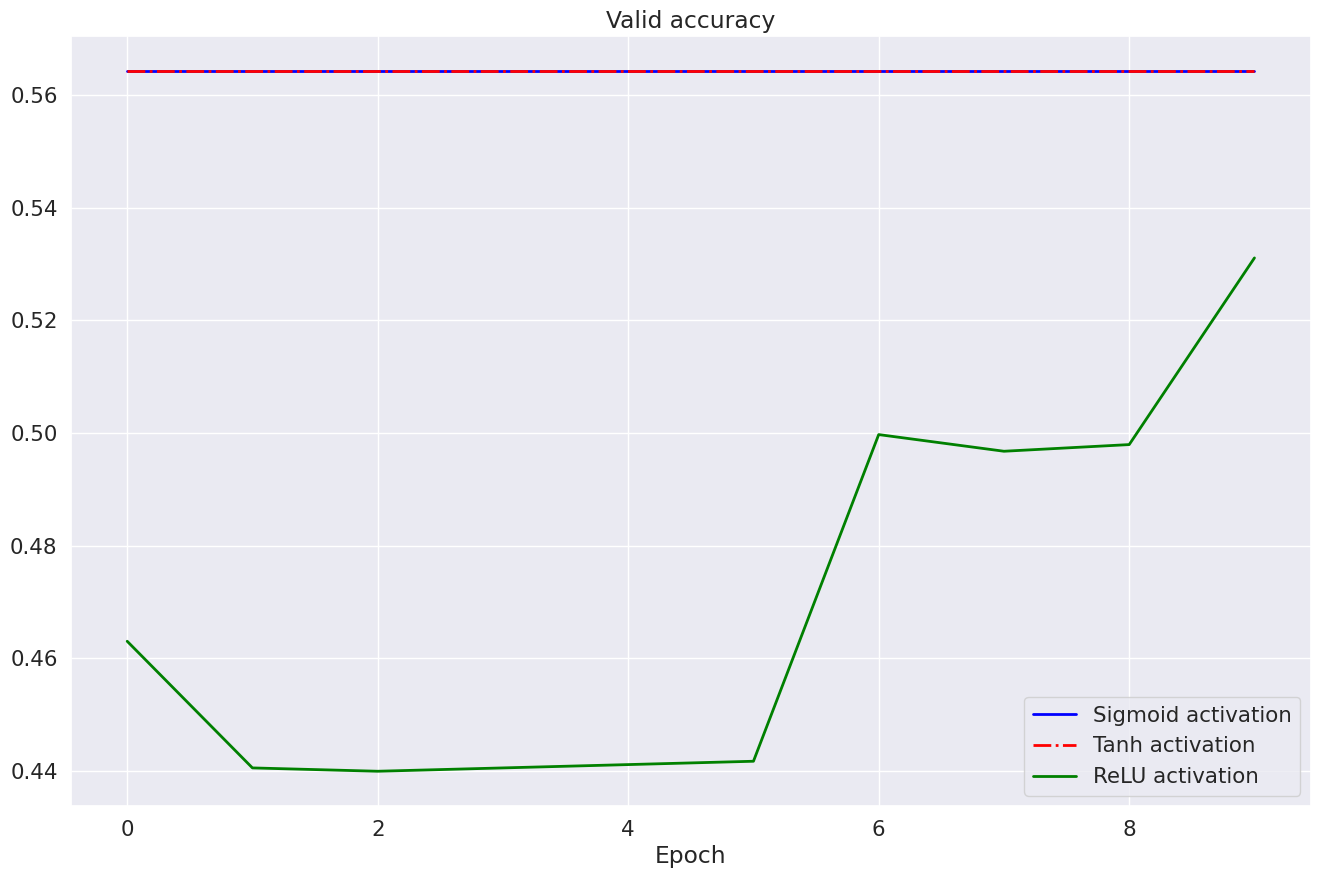

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), sigmoid_accuracy['valid'], label="Sigmoid activation", linewidth=2, color='blue')
plt.plot(range(max_epochs), tanh_accuracy['valid'], '-.', label="Tanh activation", linewidth=2, color='red',)
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2, color='green')
plt.legend()
plt.xlabel("Epoch")
plt.show()

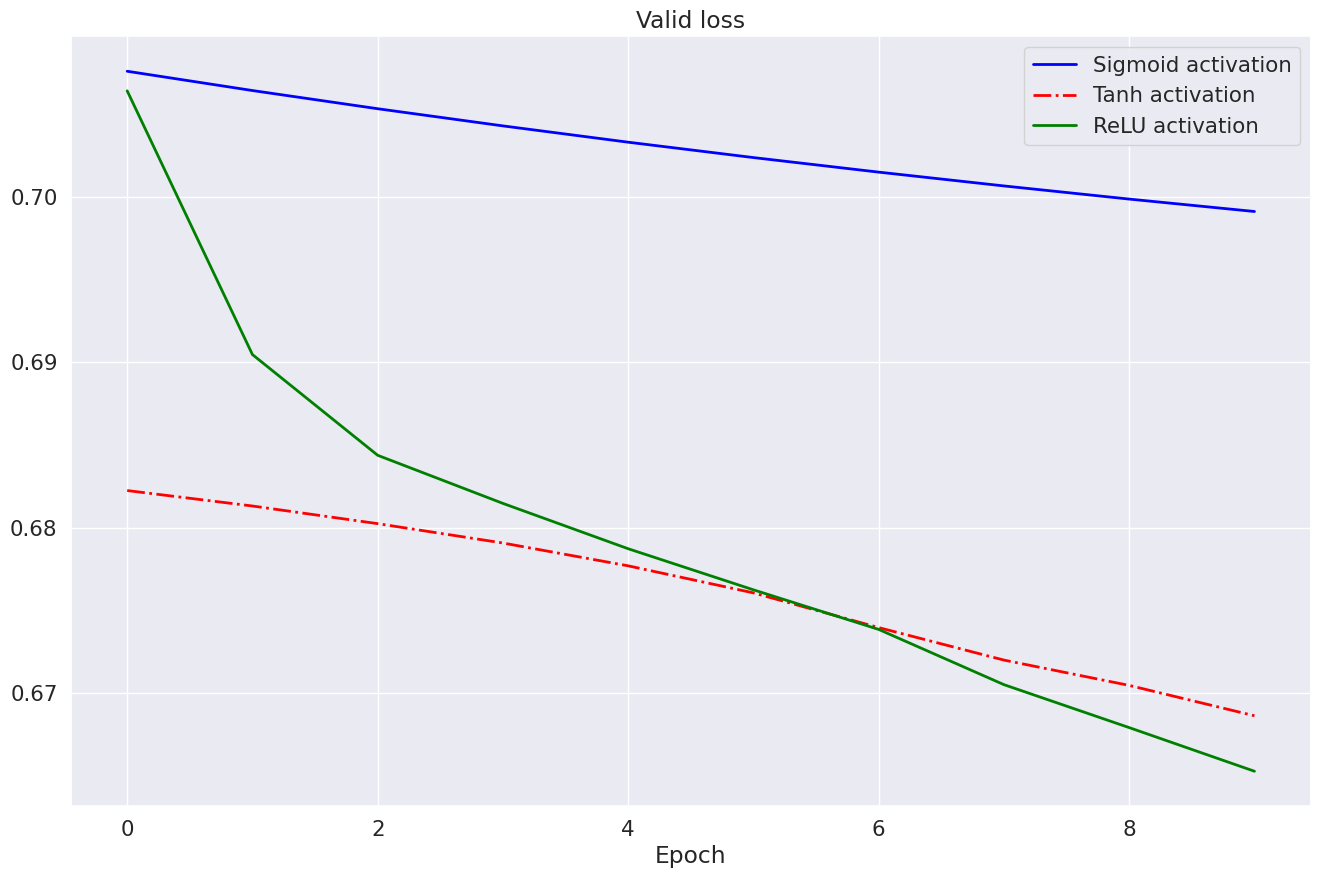

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid loss")
plt.plot(range(max_epochs), sigmoid_loss['valid'], label="Sigmoid activation", linewidth=2, color='blue')
plt.plot(range(max_epochs), tanh_loss['valid'], '-.', label="Tanh activation", linewidth=2, color='red',)
plt.plot(range(max_epochs), relu_loss['valid'], label="ReLU activation", linewidth=2, color='green')
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
def test_optimizer(optimizer, model):
    criterion = nn.BCEWithLogitsLoss()
    max_epochs = 10
    accuracy, loss = train_func(model =  model, num_epochs = max_epochs, dataloaders = dataloaders, optimizer = optimizer, loss_func = criterion)

    return accuracy, loss

model = nn.Sequential(
        nn.Linear(36, 5),
        nn.ReLU(),
        nn.Linear(5, 5),
        nn.ReLU(),
        nn.Linear(5, 5),
        nn.ReLU(),
        nn.Linear(5, 1),
        )

In [ ]:
sgd_accuracy, sgd_loss = test_optimizer(torch.optim.SGD(model.parameters()), model)
sgd_momentum_accuracy, sgd_momentum_loss = test_optimizer(torch.optim.SGD(model.parameters(), momentum=0.9), model)
rmsprop_accuracy, rmsprop_loss = test_optimizer(torch.optim.RMSprop(model.parameters()), model)
adam_accuracy, adam_loss = test_optimizer(torch.optim.Adam(model.parameters()), model)


Epoch: 1


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.5192421674728394
Loss_train: 0.7274477211934216



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.5476613640785217
Loss_test: 0.687560247523444


Epoch: 2


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.557578444480896
Loss_train: 0.68470277088993



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.5500295758247375
Loss_test: 0.6861542505877358


Epoch: 3


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.5600947141647339
Loss_train: 0.6832355407049071



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.5512137413024902
Loss_test: 0.6847980490752629


Epoch: 4


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.5614268779754639
Loss_train: 0.682010921667207



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.5523978471755981
Loss_test: 0.6836530310767037


Epoch: 5


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.5612788796424866
Loss_train: 0.6811035927736534



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.5529899597167969
Loss_test: 0.6826225008283343


Epoch: 6


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.5642392039299011
Loss_train: 0.6799562753371473



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.5571343898773193
Loss_test: 0.6815586132662637


Epoch: 7


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.5652753114700317
Loss_train: 0.679089957813047



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.5618709325790405
Loss_test: 0.6807544572012765


Epoch: 8


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.567347526550293
Loss_train: 0.6781278578740246



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.5571343898773193
Loss_test: 0.679673969745636


Epoch: 9


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.5679395794868469
Loss_train: 0.6773951256050253



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.5606868267059326
Loss_test: 0.6790901890822819


Epoch: 10


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.5691237449645996
Loss_train: 0.6767424232554886



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.5630550384521484
Loss_test: 0.6785122539315905


Epoch: 1


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.5874778032302856
Loss_train: 0.6743669116272116



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.6033155918121338
Loss_test: 0.6716010527951377


Epoch: 2


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.626998245716095
Loss_train: 0.664414902902999



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.6187092661857605
Loss_test: 0.6592076122760773


Epoch: 3


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.6358792185783386
Loss_train: 0.6502865440440628



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.6358792185783386
Loss_test: 0.6417365712778909


Epoch: 4


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.6700710654258728
Loss_train: 0.6313403799848737



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.7169923186302185
Loss_test: 0.6204935269696372


Epoch: 5


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.7464476227760315
Loss_train: 0.605396274125801



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.8022498488426208
Loss_test: 0.5862379372119904


Epoch: 6


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.8197157979011536
Loss_train: 0.5676023375313237



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.8579040765762329
Loss_test: 0.5425787780966077


Epoch: 7


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.8547957539558411
Loss_train: 0.523688905643967



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.8709295392036438
Loss_test: 0.49511360270636423


Epoch: 8


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.8687092661857605
Loss_train: 0.48682126177931734



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.8703374862670898
Loss_test: 0.46124953244413647


Epoch: 9


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.8759620785713196
Loss_train: 0.4495490215859323



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.8774423003196716
Loss_test: 0.43522724509239197


Epoch: 10


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.8863232731819153
Loss_train: 0.41657069831524257



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.8928359746932983
Loss_test: 0.3941534033843449


Epoch: 1


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.8977205157279968
Loss_train: 0.6621120015405259



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9413854479789734
Loss_test: 0.1518921490226473


Epoch: 2


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.950266420841217
Loss_train: 0.12807906714250455



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9206631183624268
Loss_test: 0.15984514408877917


Epoch: 3


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9601835608482361
Loss_train: 0.10104433039449295



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9698046445846558
Loss_test: 0.08068552639867578


Epoch: 4


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.971876859664917
Loss_train: 0.07780742849100311



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9834221601486206
Loss_test: 0.047488189967615266


Epoch: 5


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9770574569702148
Loss_train: 0.07308523237424076



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.981645941734314
Loss_test: 0.05563747816319976


Epoch: 6


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9819419980049133
Loss_train: 0.05185026021779708



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9887507557868958
Loss_test: 0.04105065802910498


Epoch: 7


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9847542643547058
Loss_train: 0.046467826965282545



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9911190271377563
Loss_test: 0.027829062093847563


Epoch: 8


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9856423735618591
Loss_train: 0.04175269333118538



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9769093990325928
Loss_test: 0.057521969079971313


Epoch: 9


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9795737266540527
Loss_train: 0.060124006289285874



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9905269145965576
Loss_test: 0.027880838007799218


Epoch: 10


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9859384298324585
Loss_train: 0.11943400480766904



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9934872984886169
Loss_test: 0.02866433228233031


Epoch: 1


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9914150238037109
Loss_train: 0.025953221802582156



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9946714043617249
Loss_test: 0.018961067594188665


Epoch: 2


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9928951859474182
Loss_train: 0.021632650335547777



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9928951859474182
Loss_test: 0.020861828034477576


Epoch: 3


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9933392405509949
Loss_train: 0.02151391684200685



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9934872984886169
Loss_test: 0.0196787694003433


Epoch: 4


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9928951859474182
Loss_train: 0.02045529491250526



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9946714043617249
Loss_test: 0.01742922793242282


Epoch: 5


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9928951859474182
Loss_train: 0.019365971846470854



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9928951859474182
Loss_test: 0.018692756129894406


Epoch: 6


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9933392405509949
Loss_train: 0.01899814607470103



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9934872984886169
Loss_test: 0.018187902917686318


Epoch: 7


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9928951859474182
Loss_train: 0.01954360670884544



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9940793514251709
Loss_test: 0.01666554735441293


Epoch: 8


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9937832951545715
Loss_train: 0.01758124505802286



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9952634572982788
Loss_test: 0.01660374301718548


Epoch: 9


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9933392405509949
Loss_train: 0.017745691134137504



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9952634572982788
Loss_test: 0.01703349653066003


Epoch: 10


  0%|          | 0/53 [00:00<?, ?it/s]

Accuracy_train: 0.9942273497581482
Loss_train: 0.016636346598630242



  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy_test: 0.9952634572982788
Loss_test: 0.01564930278358848



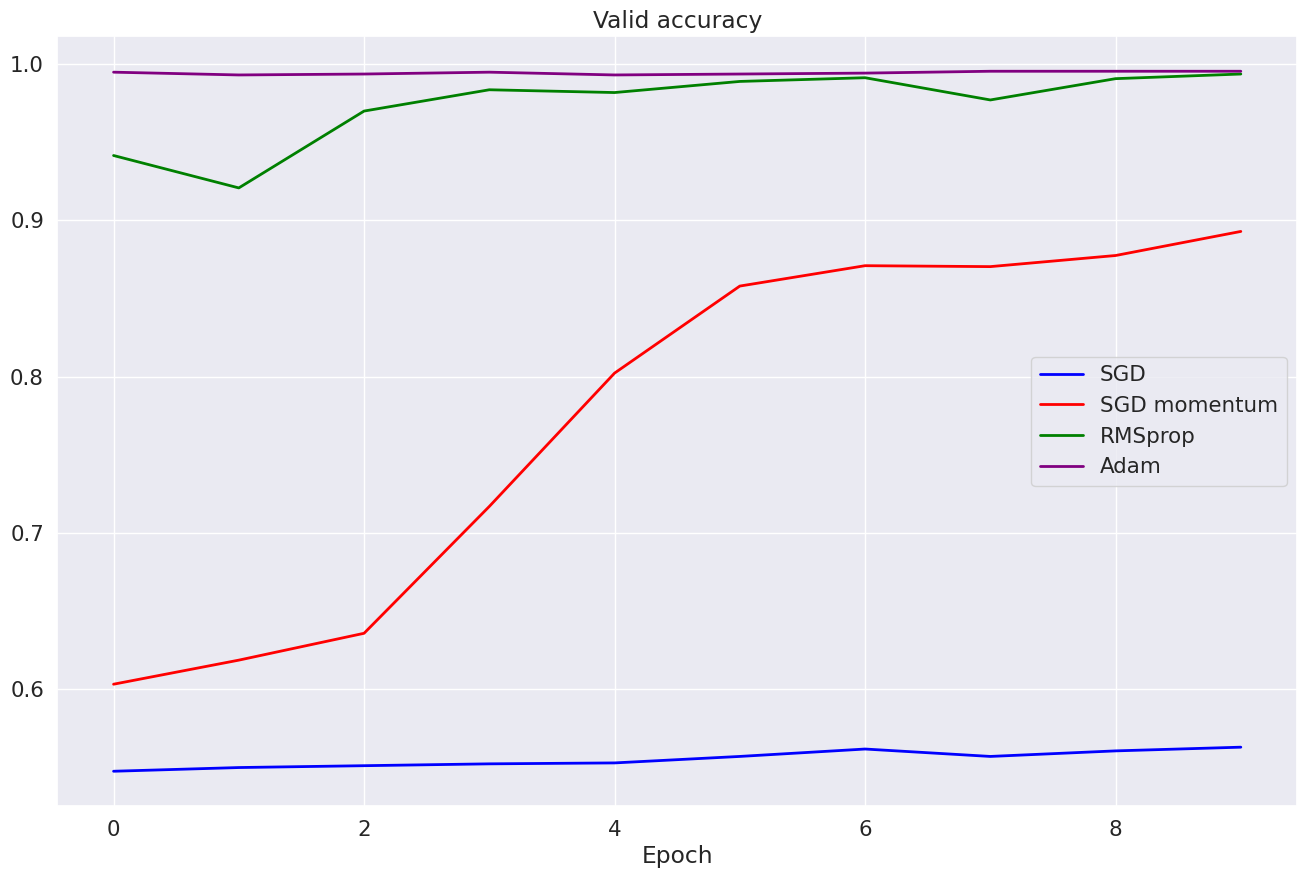

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), sgd_accuracy['valid'], label="SGD", linewidth=2, color='blue')
plt.plot(range(max_epochs), sgd_momentum_accuracy['valid'], label="SGD momentum", linewidth=2, color='red',)
plt.plot(range(max_epochs), rmsprop_accuracy['valid'], label="RMSprop", linewidth=2, color='green')
plt.plot(range(max_epochs), adam_accuracy['valid'], label="Adam", linewidth=2, color='purple')
plt.legend()
plt.xlabel("Epoch")
plt.show()

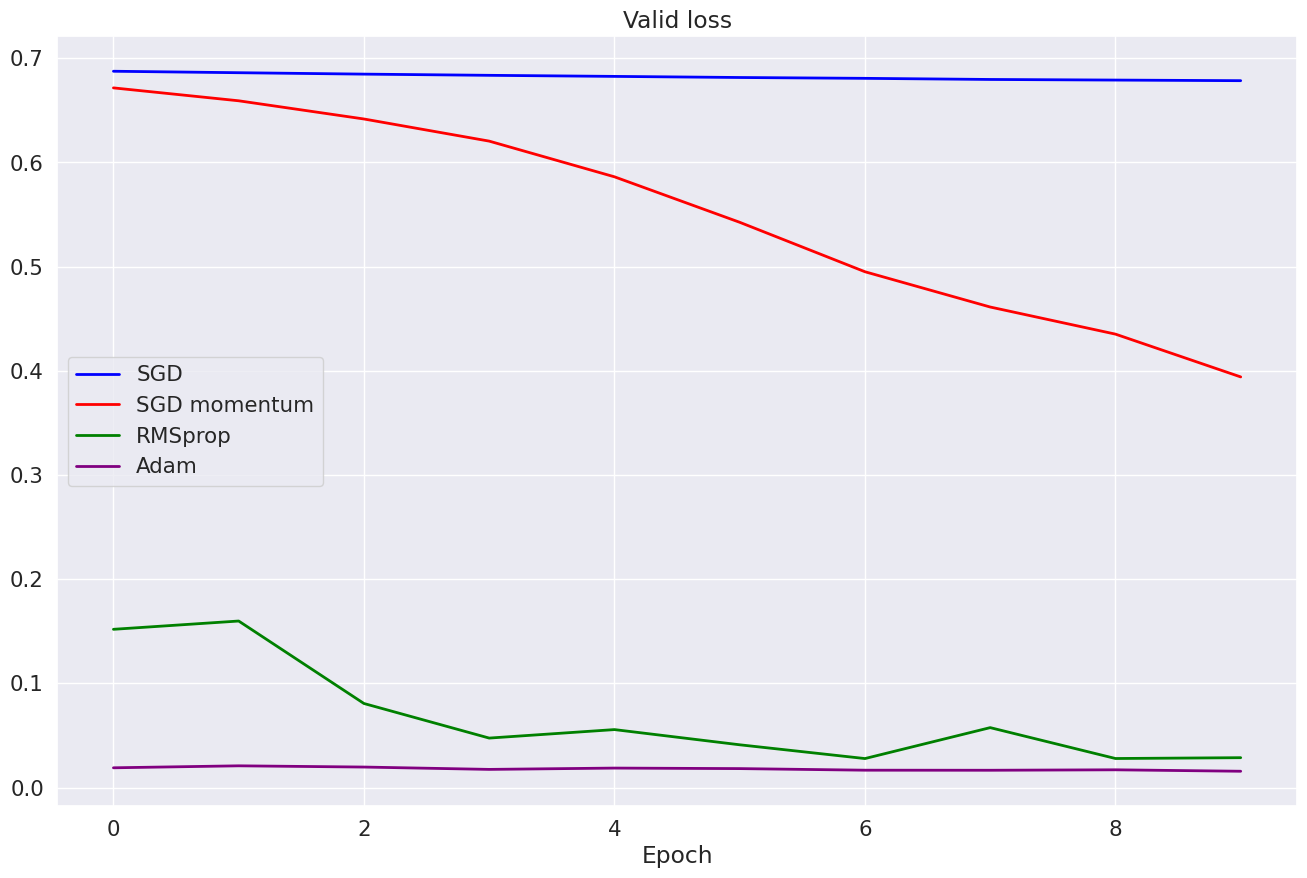

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid loss")
plt.plot(range(max_epochs), sgd_loss['valid'], label="SGD", linewidth=2, color='blue')
plt.plot(range(max_epochs), sgd_momentum_loss['valid'], label="SGD momentum", linewidth=2, color='red',)
plt.plot(range(max_epochs), rmsprop_loss['valid'], label="RMSprop", linewidth=2, color='green')
plt.plot(range(max_epochs), adam_loss['valid'], label="Adam", linewidth=2, color='purple')
plt.legend()
plt.xlabel("Epoch")
plt.show()